In [ ]:
import numpy as np
import pandas as pd
from os.path  import join
%matplotlib inline
import random
import matplotlib.pyplot as plt
import struct
from array import array
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report

In [ ]:
!kaggle datasets download -d hojjatk/mnist-dataset
!makdir mnist-dataset
!unzip -o mnist-dataset.zip -d mnist-dataset
!rm mnist-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
 91% 20.0M/22.0M [00:01<00:00, 28.7MB/s]
100% 22.0M/22.0M [00:01<00:00, 17.5MB/s]
/bin/bash: line 1: makdir: command not found
Archive:  mnist-dataset.zip
  inflating: mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: mnist-dataset/t10k-images.idx3-ubyte  
  inflating: mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: mnist-dataset/t10k-labels.idx1-ubyte  
  inflating: mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: mnist-dataset/train-images.idx3-ubyte  
  inflating: mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: mnist-dataset/train-labels.idx1-ubyte  


In [ ]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())

        images = np.zeros((size, rows, cols))

        for i in range(size):
            images[i] = np.array(image_data[i * rows * cols:(i + 1) * rows * cols]).reshape(rows, cols)

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [ ]:
input_path = '/content/mnist-dataset'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [ ]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

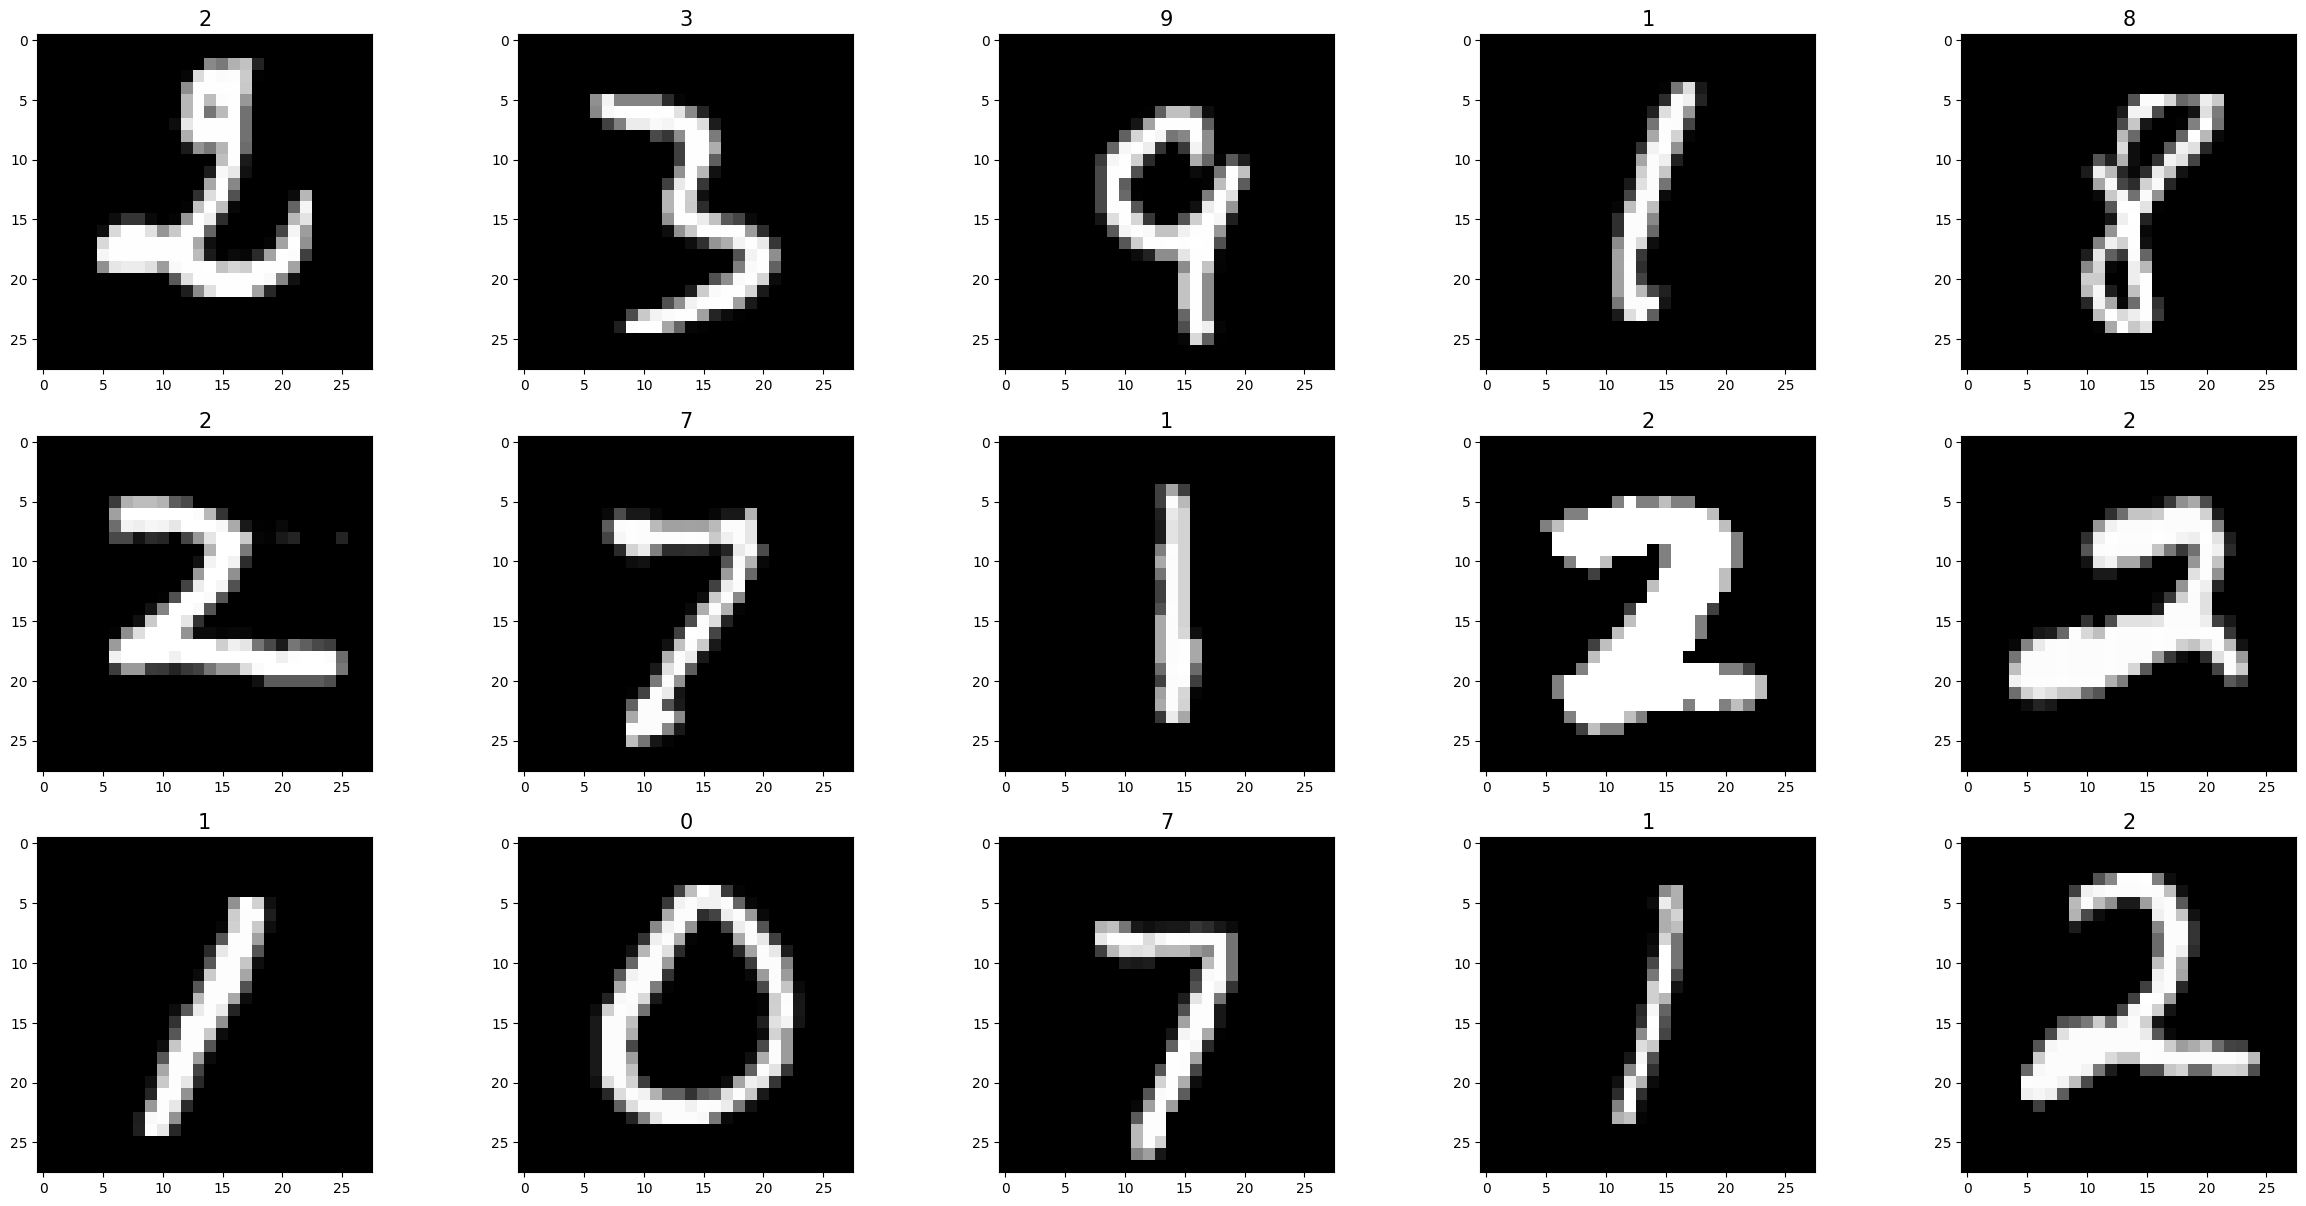

In [ ]:
#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append( str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append(str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
print(f"len x_train: {len(x_train)}")
print(f"len x_test:  {len(x_test)}")
print(f"Counter label y_train: {np.unique(y_train, return_counts=True)}")
print(f"Counter label y_test:  {np.unique(y_test, return_counts=True)}")

len x_train: 60000
len x_test:  10000
Counter label y_train: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
Counter label y_test:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))


In [ ]:
# Reshape nos dados para adicionar o canal que é necessario para a cnn
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [ ]:
# Normalize
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
# variavel categorica para 1 hot code
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# CNN

In [ ]:
# Define the CNN model
model_cnn = keras.Sequential([
  keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  keras.layers.MaxPooling2D((2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation='softmax')
])

# Compile the model_cnn
model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model_cnn
history_cnn = model_cnn.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)])

# Evaluate the model_cnn
test_loss, test_acc = model_cnn.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8913 - loss: 0.4018 - val_accuracy: 0.9746 - val_loss: 0.0872
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9755 - loss: 0.0843 - val_accuracy: 0.9793 - val_loss: 0.0657
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9823 - loss: 0.0602 - val_accuracy: 0.9824 - val_loss: 0.0545
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9856 - loss: 0.0495 - val_accuracy: 0.9825 - val_loss: 0.0524
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9882 - loss: 0.0400 - val_accuracy: 0.9821 - val_loss: 0.0559
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9775 - loss: 0.0693
Test accuracy: 0.9821000099182129


In [ ]:
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 5408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          54,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 163,232 (637.63 KB)

 Trainable params: 54,410 (212.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 108,822 (425.09 KB)

In [ ]:
y_pred_train = model_cnn.predict(x_train)
y_pred_test = model_cnn.predict(x_test)


y_pred_train = (y_pred_train > 0.5).astype(float)
y_pred_test = (y_pred_test > 0.5).astype(float)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
print(len(y_pred_train))
print(len(y_pred_test))

60000
10000


In [ ]:
print(y_pred_train[0])
print(y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5923
           1       1.00      0.99      1.00      6742
           2       1.00      0.97      0.99      5958
           3       1.00      0.98      0.99      6131
           4       0.99      1.00      0.99      5842
           5       0.98      0.99      0.99      5421
           6       0.99      1.00      1.00      5918
           7       0.98      0.99      0.99      6265
           8       0.99      0.97      0.98      5851
           9       0.98      0.99      0.98      5949

   micro avg       0.99      0.99      0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000
 samples avg       0.99      0.99      0.99     60000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.96      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.97      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.97      0.99      0.98      1028
           8       0.99      0.95      0.97       974
           9       0.99      0.97      0.98      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000
 samples avg       0.98      0.98      0.98     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Classica

In [ ]:
model = keras.Sequential([
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)])

test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8132 - loss: 0.7171 - val_accuracy: 0.9153 - val_loss: 0.3079
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9157 - loss: 0.3109 - val_accuracy: 0.9221 - val_loss: 0.2831
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9202 - loss: 0.2801 - val_accuracy: 0.9246 - val_loss: 0.2709
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9217 - loss: 0.2769 - val_accuracy: 0.9257 - val_loss: 0.2708
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9258 - loss: 0.2670 - val_accuracy: 0.9239 - val_loss: 0.2702
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9132 - loss: 0.3048
Test accuracy: 0.9239000082015991


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (32, 784)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 10)                    │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,552 (92.00 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,702 (61.34 KB)

In [ ]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)


y_pred_train = (y_pred_train > 0.5).astype(float)
y_pred_test = (y_pred_test > 0.5).astype(float)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5923
           1       0.98      0.96      0.97      6742
           2       0.94      0.90      0.92      5958
           3       0.92      0.90      0.91      6131
           4       0.92      0.95      0.93      5842
           5       0.93      0.85      0.89      5421
           6       0.96      0.95      0.96      5918
           7       0.95      0.93      0.94      6265
           8       0.91      0.88      0.90      5851
           9       0.96      0.85      0.90      5949

   micro avg       0.94      0.91      0.93     60000
   macro avg       0.94      0.91      0.93     60000
weighted avg       0.94      0.91      0.93     60000
 samples avg       0.91      0.91      0.91     60000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.97      0.98      1135
           2       0.95      0.89      0.92      1032
           3       0.92      0.91      0.91      1010
           4       0.91      0.94      0.93       982
           5       0.93      0.84      0.88       892
           6       0.96      0.94      0.95       958
           7       0.94      0.91      0.93      1028
           8       0.89      0.88      0.89       974
           9       0.95      0.84      0.89      1009

   micro avg       0.94      0.91      0.93     10000
   macro avg       0.94      0.91      0.92     10000
weighted avg       0.94      0.91      0.93     10000
 samples avg       0.91      0.91      0.91     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Comparação

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss perceptron', color='white')
plt.ylabel('Loss', color = 'white')
plt.xlabel('Epoch', color='white')
plt.legend(['Train', 'Validation'], loc='upper right')

# Mudar cor dos eixos para branco
ax = plt.gca()
ax.set_facecolor('black')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')


plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss CNN', color='white')
plt.ylabel('Loss', color = 'white')
plt.xlabel('Epoch', color='white')
plt.legend(['Train', 'Validation'], loc='upper right')

# Mudar cor dos eixos para branco
ax = plt.gca()
ax.set_facecolor('black')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.gcf().set_facecolor('black')
plt.show()

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy perceptron', color='white')
plt.ylabel('accuracy', color='white')
plt.xlabel('Epoch', color='white')
plt.legend(['Train', 'Validation'], loc='lower right')

# Mudar cor dos eixos para branco
ax = plt.gca()
ax.set_facecolor('black')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')


plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy CNN', color='white')
plt.ylabel('accuracy', color='white')
plt.xlabel('Epoch', color='white')
plt.legend(['Train', 'Validation'], loc='lower right')

# Mudar cor dos eixos para branco
ax = plt.gca()
ax.set_facecolor('black')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')


plt.gcf().set_facecolor('black')
plt.show()

In [ ]:
# Fazer previsões nos dados de teste
y_pred_cnn = model_cnn.predict(x_test)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
# Calcular a matriz de confusão
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
cm = confusion_matrix(y_test, y_pred)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Plotar a matriz de confusão da Perceptron
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp_test.plot(cmap=plt.cm.Blues, ax=ax[1], values_format='d')
ax[0].set_title("Matriz de Confusão - Perceptron", color='white')
ax[0].set_facecolor('black')

# Alterar a cor das bordas do gráfico (spines) para branco
ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('white')
ax[0].spines['right'].set_color('white')
ax[0].spines['left'].set_color('white')

ax[0].set_xlabel('Predicted Label', color='white')
ax[0].set_ylabel('True Label', color='white')

ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')

# Plotar a matriz de confusão da CNN
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=range(10))
disp_train.plot(cmap=plt.cm.Blues, ax=ax[0], values_format='d')
ax[1].set_title("Matriz de Confusão - CNN", color='white')
ax[1].set_facecolor('black')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('white')
ax[1].spines['right'].set_color('white')
ax[1].spines['left'].set_color('white')

ax[1].set_xlabel('Predicted Label', color='white')
ax[1].set_ylabel('True Label', color='white')

ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')

plt.gcf().set_facecolor('black')
plt.show()

# 2º